<a href="https://colab.research.google.com/github/JeanMusenga/PhD-Thesis_2024_Musenga/blob/main/BERT_ARPs_Classification_With_PredictionMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://chatgpt.com/share/b8196226-48d6-49a4-b448-db1ac491d8a5

https://chatgpt.com/share/d4841f05-7b85-45ea-ae25-470f9c2482d0

In [ ]:
pip install datasets

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
from datasets import Dataset, load_metric
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [ ]:
np.random.seed(42) #The random seed helps in the reproduction of the results

# Load the dataset

In [3]:
# Load the dataset
file_path = '/content/posts.xlsx'
df = pd.read_excel(file_path)

# Split the dataset

In [4]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)


# Tokenize the data

In [5]:
# Tokenize the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['Question_body'], padding='max_length', truncation=True)

# Convert DataFrame to Dataset

In [6]:
# Convert DataFrame to Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Tokenize the dataset

In [7]:
# Tokenize the dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10452 [00:00<?, ? examples/s]

Map:   0%|          | 0/4480 [00:00<?, ? examples/s]

In [8]:
# Rename label column to 'labels' for compatibility with the Trainer
train_dataset = train_dataset.rename_column("Label", "labels")
test_dataset = test_dataset.rename_column("Label", "labels")

In [9]:
# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


In [ ]:
# Loading the BERT model

In [10]:
# Loading the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define Training Arguments

In [11]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Initialize the Adam optimizer

In [12]:
# Initialize the Adam optimizer
adam_optimizer = optim.Adam(model.parameters(), lr=2e-5)

Initialize Trainer
The Trainer class is initialized with the model, training arguments, and datasets.

In [13]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    optimizers=(adam_optimizer, None)
)

# Train the Model
The train method is called to start the training process.

In [14]:
trainer.train()

Step,Training Loss
10,0.703000
20,0.699300
30,0.679800
40,0.678200
50,0.671400
60,0.625000
70,0.603900
80,0.541500
90,0.535900
100,0.487400


TrainOutput(global_step=3921, training_loss=0.11544199622979576, metrics={'train_runtime': 2962.7999, 'train_samples_per_second': 10.583, 'train_steps_per_second': 1.323, 'total_flos': 8250110251868160.0, 'train_loss': 0.11544199622979576, 'epoch': 3.0})

# Evaluate the model
The evaluate method is called to evaluate the model on the test dataset.


In [22]:
# Evaluate the model
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = test_dataset['labels'].numpy()

In [21]:
# Calculate metrics
#precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])
#accuracy = accuracy_score(y_true, y_pred)

In [17]:
#print(f'Accuracy: {accuracy}')
#print(f'Class 0 - Precision: {precision[0]}, Recall: {recall[0]}, F1 score: {f1[0]}')
print(f'Class 1 - Precision: {precision[1]}, Recall: {recall[1]}, F1 score: {f1[1]}')

Accuracy: 0.9774553571428571
Class 0 - Precision: 0.9931631722880584, Recall: 0.9620309050772627, F1 score: 0.9773491814308141
Class 1 - Precision: 0.9623797025371829, Recall: 0.9932279909706546, F1 score: 0.9775605421017551


In [23]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0 = conf_matrix[0, 0]
FN_0 = conf_matrix[0, 1]
FP_0 = conf_matrix[1, 0]
TN_0 = conf_matrix[1, 1]

TP_1 = conf_matrix[1, 1]
FN_1 = conf_matrix[1, 0]
FP_1 = conf_matrix[0, 1]
TN_1 = conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}, Support: {support_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}, Support: {support_class[1]}')


Class 0 - Precision: 0.9931631722880584, Recall: 0.9620309050772627, Accuracy: 0.9774553571428571, F1-score: 0.9773491814308141, Support: 2265
Class 1 - Precision: 0.9623797025371829, Recall: 0.9932279909706546, Accuracy: 0.9774553571428571, F1-score: 0.9775605421017551, Support: 2215


# Save the model and tokenizer

The model and tokenizer are saved in the directory you specify in the save_pretrained method. In the code example provided, the model and tokenizer are saved in the ./saved_model directory relative to the current working directory where the script is executed

In [ ]:

saved_model_path = './saved_model'
model.save_pretrained(saved_model_path)
tokenizer.save_pretrained(saved_model_path)

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

# List the contents of the saved model directory
You can verify the saved files by checking the ./saved_model directory. This directory should contain the following files:
config.json: Configuration file for the model.
pytorch_model.bin: The model's weights.
tokenizer_config.json: Configuration file for the tokenizer.
vocab.txt: Vocabulary file used by the tokenizer.
special_tokens_map.json

# //////////////To trust the prediction results of a BERT model//////////////////
To trust the prediction results of a BERT model (or any machine learning model), you should evaluate its performance using various metrics and techniques. Here are some steps to help you build confidence in the model's predictions:

# Learning Curves
Plot learning curves to see how the model's performance evolves with the amount of training data and epochs.

In [ ]:
import os
print("Saved model files:", os.listdir(saved_model_path))

# Load the model and tokenizer
loaded_model = BertForSequenceClassification.from_pretrained(saved_model_path)
loaded_tokenizer = BertTokenizer.from_pretrained(saved_model_path)

Saved model files: ['config.json', 'tokenizer_config.json', 'special_tokens_map.json', 'model.safetensors', 'vocab.txt']


In [ ]:
import matplotlib.pyplot as plt

# Assuming training and validation metrics are recorded during training
plt.plot(training_args.logging_steps, train_loss, label='Training Loss')
plt.plot(training_args.logging_steps, val_loss, label='Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
A confusion matrix provides a visual representation of the model's performance by showing the counts of true positive, true negative, false positive, and false negative predictions.

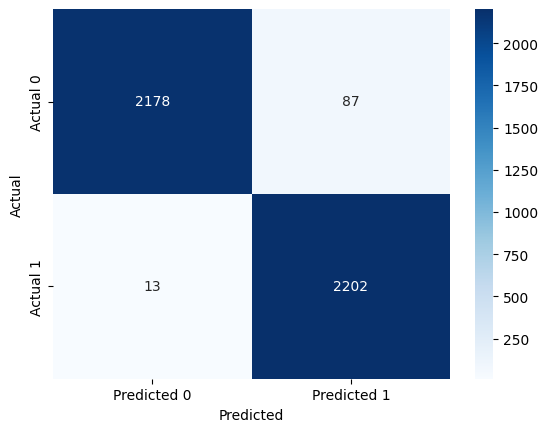

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Cross-Validation
Use cross-validation to assess the model's performance across different subsets of the data, ensuring that the evaluation is robust and not biased by a particular train-test split.

In [ ]:
from sklearn.model_selection import cross_val_score
from transformers import BertForSequenceClassification

# Assuming you have a scikit-learn compatible pipeline
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# Use cross_val_score with a compatible classifier pipeline
scores = cross_val_score(your_pipeline, X, y, cv=5, scoring='accuracy')
print(f'Cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean()}')

In [ ]:
pip install shap

In [ ]:
import shap

# Assuming you have a trained model and a tokenizer
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(test_dataset)
shap.summary_plot(shap_values, test_dataset)